This is a private hackathon for the July-August 2020 cohort of the Zindi mentor program.

Financial Inclusion remains one of the main obstacles to economic and human development in Africa. For example, across Kenya, Rwanda, Tanzania, and Uganda only 9.1 million adults (or 13.9% of the adult population) have access to or use a commercial bank account.

Traditionally, access to bank accounts has been regarded as an indicator of financial inclusion. Despite the proliferation of mobile money in Africa, and the growth of innovative fintech solutions, banks still play a pivotal role in facilitating access to financial services. Access to bank accounts enable households to save and facilitate payments while also helping businesses build up their credit-worthiness and improve their access to other finance services. Therefore, access to bank accounts is an essential contributor to long-term economic growth.

The objective of this competition is to create a machine learning model to predict which individuals are most likely to have or use a bank account. The models and solutions developed can provide an indication of the state of financial inclusion in Kenya, Rwanda, Tanzania and Uganda, while providing insights into some of the key demographic factors that might drive individuals’ financial outcomes.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!pip3 install catboost

     |████████████████████████████████| 64.8MB 63kB/s 


In [4]:

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import KFold


from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn import svm
import lightgbm as lgb
import xgboost
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Get the data from the my drive

In [5]:
path='./drive/My Drive/Zindi_mentorship'

train=pd.read_csv(path+"/Train_v2.csv")
test=pd.read_csv(path +"/Test_v2.csv")

## Keep the variables country and id for my submission

In [6]:
id=test['uniqueid']
country=test['country']

## Data processing

In this part of our code, we will explore the data. See how it's structure in oder to know how to process it.

In [7]:
train.describe()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB


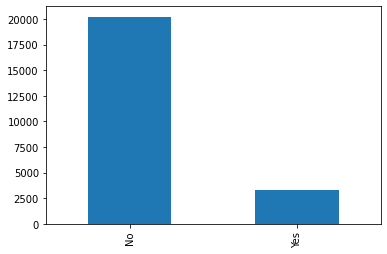

In [8]:
train.bank_account.value_counts().plot(kind='bar')

In [9]:
train.bank_account.value_counts()

No     20212
Yes     3312
Name: bank_account, dtype: int64

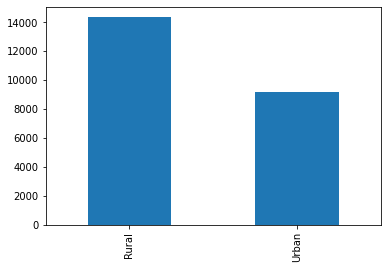

In [10]:
train.location_type.value_counts().plot(kind='bar')


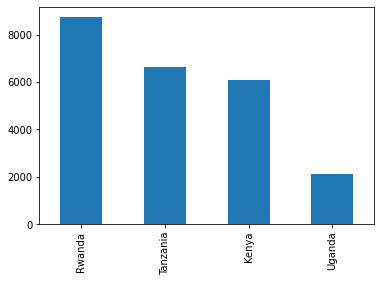

In [11]:
train.country.value_counts().plot(kind='bar')


In [12]:
train['bank_account']=np.where(train['bank_account']=='Yes',1,0)


In [13]:

train['year_'] = train['year']
test['year_'] = test['year']
float_array = train[['household_size', 'age_of_respondent', 'year_']].values.astype(float)
float_array = test[['household_size', 'age_of_respondent', 'year_']].values.astype(float)

Here we transform the categorical variables to numerical variables

In [14]:
le = LabelEncoder()
train['country_'] = train['country']
test['country_'] = test['country']

categ = ['relationship_with_head', 'marital_status', 'education_level', 'job_type', 'country_']
train = pd.get_dummies(train, prefix_sep='_', columns = categ)

test = pd.get_dummies(test, prefix_sep='_', columns = categ)

train['location_type'] = le.fit_transform(train['location_type'])
train['cellphone_access'] = le.fit_transform(train['cellphone_access'])
train['gender_of_respondent'] = le.fit_transform(train['gender_of_respondent'])


test['location_type'] = le.fit_transform(test['location_type'])
test['cellphone_access'] = le.fit_transform(test['cellphone_access'])
test['gender_of_respondent'] = le.fit_transform(test['gender_of_respondent'])


train.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,year_,relationship_with_head_Child,relationship_with_head_Head of Household,relationship_with_head_Other non-relatives,relationship_with_head_Other relative,relationship_with_head_Parent,relationship_with_head_Spouse,marital_status_Divorced/Seperated,marital_status_Dont know,marital_status_Married/Living together,marital_status_Single/Never Married,marital_status_Widowed,education_level_No formal education,education_level_Other/Dont know/RTA,education_level_Primary education,education_level_Secondary education,education_level_Tertiary education,education_level_Vocational/Specialised training,job_type_Dont Know/Refuse to answer,job_type_Farming and Fishing,job_type_Formally employed Government,job_type_Formally employed Private,job_type_Government Dependent,job_type_Informally employed,job_type_No Income,job_type_Other Income,job_type_Remittance Dependent,job_type_Self employed,country__Kenya,country__Rwanda,country__Tanzania,country__Uganda
0,Kenya,2018,uniqueid_1,1,0,1,3,24,0,2018,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
1,Kenya,2018,uniqueid_2,0,0,0,5,70,0,2018,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
2,Kenya,2018,uniqueid_3,1,1,1,5,26,1,2018,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0
3,Kenya,2018,uniqueid_4,0,0,1,5,34,0,2018,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
4,Kenya,2018,uniqueid_5,0,1,0,8,26,1,2018,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


## Split the data to create train, validation set

In [15]:

X_train_data = train.drop(['year', 'uniqueid', 'bank_account', 'country'], axis=1)
y = train['bank_account']

X_test_data = test.drop(['year', 'uniqueid', 'country'], axis=1)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
X_train_data_rescaled = scaler.fit_transform(X_train_data)
X_test_data_rescaled = scaler.fit_transform(X_test_data)


In [16]:
X_train_data_rescaled.shape


(23524, 37)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_train_data_rescaled, y, stratify = y, test_size = 0.2, random_state=42)
print(X_train.shape, y_train.shape)

(18819, 37) (18819,)


### Model performance!

### logistic regression

In [35]:
model_logist=LogisticRegression(C=10.0, fit_intercept=True, intercept_scaling=1, max_iter=100,n_jobs=3,solver='newton-cg')
model_logist.fit(X_train, y_train)
pred=model_logist.predict(X_test)
1-accuracy_score(y_test,pred)

0.11158342189160464

### Random forest
Here we try the random forest model. We perform a gridsearch to look for the best parameters


In [19]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [5,10,15,20,30]

min_samples_split = [2, 5, 6]
min_samples_leaf = [1, 2, 4,6]
bootstrap = [True, False]


model_rf =  RandomForestClassifier()

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


rf_random = RandomizedSearchCV(estimator = model_rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: ignored

In [36]:
best_params={'n_estimators': 311, 
             'min_samples_split': 5, 
             'min_samples_leaf': 2, 
             'max_features': 'sqrt', 
             'max_depth': 15, 
             'bootstrap': True}


model_randf = RandomForestClassifier(**best_params)
model_randf.fit(X_train,y_train)
pred = model_randf.predict(X_test)
print(1-accuracy_score(y_test,pred))

0.10839532412327313


### xgboost classifier
Here we train a xgboost classifier with gridsearch to find the best parameters

In [ ]:
model = XGBClassifier()

param_grid = {'min_child_weight': [2, 3,4,5],
        'gamma': [2,4,5,6,8],
        'subsample': [0.6,0.7, 0.8],
        'max_depth': [5,10,15],
        'max_delta_step':[0, 1, 2],
        'lambda':[1,1.5,2],
        'alpha':[0,1,1.5],
        'lr':[0.01,0.05,0.07, 0.1],
        'cv':[4,5,6],
        'verbosity':0

        }
model2 = GridSearchCV(model, param_grid)
model2.fit(X_train, y_train)
print(model2.best_params_)

In [37]:

best_params={'min_child_weight' :5, 
            'gamma ': 0.8,
            'subsample':  0.6, 
            'colsample_bytree': 0.6, 
            'max_depth' : 5,
            'learn_rate':0.001,
            'reg_lambda':1.2,
             'reg_alpha':1

              }

xgb_model= XGBClassifier(**best_params)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
print("Error rate of xgboost classifier: ", 1 - accuracy_score(y_test, y_pred))
confusion_matrix(y_pred, y_test)

Error rate of xgboost classifier:  0.10839532412327313


array([[3944,  411],
       [  99,  251]])

In [33]:
final_pred=xgb_model.predict(X_test_data_rescaled)
col=[id[i] +' '+'x'+' '+ country[i] for i in range(len(test))]

test['bank_account']=final_pred
test['uniqueid']=col


pred=test[['uniqueid','bank_account']]

# pred.columns
pred.to_csv('reg.csv', index=False)

### Lightgbm classifier

In [ ]:
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'nthread': 3, # Updated from nthread
          'num_leaves': 64,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error'} 

gridParams = {
    'learning_rate': [0.005, 0.01,0.05,0.07, 0.1],
    'n_estimators': [40, 100,200,1000],
    'num_leaves': [6,8,12,16],
    'random_state' : [42,501],
    'colsample_bytree' : [0.6, 0.65,0.8],
    'subsample' : [0.6,0.7,0.75, 0.8],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    }

mdl = lgb.LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = 3,
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          scale_pos_weight = params['scale_pos_weight'])

mdl.get_params().keys()

grid = GridSearchCV(mdl, gridParams,
                    verbose=0,
                    cv=5,
                    n_jobs=2)
grid.fit(X_train, y_train)

KeyboardInterrupt: ignored

In [22]:
best_paramL={'boosting_type': 'gbdt',
 'colsample_bytree': 0.65,
 'learning_rate': 0.01,
 'n_estimators': 100,
 'num_leaves': 6,
 'objective': 'binary',
 'random_state': 42,
 'reg_alpha': 2,
 'reg_lambda': 1,
 'subsample': 0.7}

model_lgb=lgb.LGBMClassifier(**best_params)
model_lgb.fit(X_train,y_train)
1 - accuracy_score(y_test,model_lgb.predict(X_test))


0.11030818278427201

### using catboost

In [ ]:
catb_params={'iterations' :[10, 500, 700,1000],
             'learning_rate' :[0.001,0.01,0.05,0.07],
             'l2_leaf_reg': [0.001,0.003,0.06,1]
    
}

model_cat = CatBoostClassifier(iterations=catb_params['iterations'],
                               learning_rate=catb_params['learning_rate'],
                               l2_leaf_reg=catb_params['l2_leaf_reg']
                               )

model_cat.get_params().keys()

grid = GridSearchCV(model_cat, catb_params,
                    verbose=0,
                    cv=5,
                    n_jobs=2)
grid.fit(X_train, y_train)

0:	learn: 0.6848018	total: 14.8ms	remaining: 14.8s
1:	learn: 0.6760097	total: 25.8ms	remaining: 12.9s
2:	learn: 0.6663854	total: 37.9ms	remaining: 12.6s
3:	learn: 0.6583474	total: 49.7ms	remaining: 12.4s
4:	learn: 0.6489386	total: 62.4ms	remaining: 12.4s
5:	learn: 0.6410533	total: 74.4ms	remaining: 12.3s
6:	learn: 0.6317740	total: 85.6ms	remaining: 12.1s
7:	learn: 0.6245449	total: 97.2ms	remaining: 12s
8:	learn: 0.6164768	total: 108ms	remaining: 11.9s
9:	learn: 0.6082852	total: 120ms	remaining: 11.9s
10:	learn: 0.6012242	total: 130ms	remaining: 11.7s
11:	learn: 0.5936416	total: 141ms	remaining: 11.6s
12:	learn: 0.5861576	total: 153ms	remaining: 11.6s
13:	learn: 0.5794122	total: 164ms	remaining: 11.6s
14:	learn: 0.5735767	total: 176ms	remaining: 11.6s
15:	learn: 0.5673294	total: 186ms	remaining: 11.5s
16:	learn: 0.5610007	total: 197ms	remaining: 11.4s
17:	learn: 0.5541059	total: 208ms	remaining: 11.4s
18:	learn: 0.5472750	total: 228ms	remaining: 11.8s
19:	learn: 0.5415473	total: 240ms	r

GridSearchCV(cv=5, error_score=nan,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f6e055b90b8>,
             iid='deprecated', n_jobs=2,
             param_grid={'iterations': [10, 500, 700, 1000],
                         'l2_leaf_reg': [0.001, 0.003, 0.06, 1],
                         'learning_rate': [0.001, 0.01, 0.05, 0.07]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
grid.best_params_

{'iterations': 1000, 'l2_leaf_reg': 0.003, 'learning_rate': 0.01}

In [23]:
params={'depth': 6,
 'iterations': 1000,
 'l2_leaf_reg': 0.003,
 'random_seed': 42,
 'learning_rate':0.01}
catboost_model = CatBoostClassifier(**params)
catboost_model.fit(X_train,y_train)
1 - accuracy_score(y_test,catboost_model.predict(X_test))

0:	learn: 0.6824896	total: 60.5ms	remaining: 1m
1:	learn: 0.6742124	total: 71.5ms	remaining: 35.7s
2:	learn: 0.6647676	total: 82.2ms	remaining: 27.3s
3:	learn: 0.6558373	total: 92.5ms	remaining: 23s
4:	learn: 0.6462061	total: 104ms	remaining: 20.6s
5:	learn: 0.6373817	total: 112ms	remaining: 18.5s
6:	learn: 0.6284745	total: 123ms	remaining: 17.5s
7:	learn: 0.6200172	total: 134ms	remaining: 16.6s
8:	learn: 0.6114440	total: 145ms	remaining: 16s
9:	learn: 0.6047972	total: 156ms	remaining: 15.4s
10:	learn: 0.5972004	total: 166ms	remaining: 15s
11:	learn: 0.5905464	total: 177ms	remaining: 14.6s
12:	learn: 0.5827976	total: 188ms	remaining: 14.3s
13:	learn: 0.5772787	total: 197ms	remaining: 13.9s
14:	learn: 0.5697840	total: 207ms	remaining: 13.6s
15:	learn: 0.5636468	total: 218ms	remaining: 13.4s
16:	learn: 0.5576598	total: 227ms	remaining: 13.1s
17:	learn: 0.5522362	total: 238ms	remaining: 13s
18:	learn: 0.5461737	total: 248ms	remaining: 12.8s
19:	learn: 0.5401593	total: 262ms	remaining: 12.

0.1094580233793836

### Ensembling the models
Here we ensempble the models. first we ensemble all the the models but the result was not to very good  so try many possibility.The best is  given by ensembling logistic regression, random forest and xgboost.

In [24]:
!pip install statistics

  Created wheel for statistics: filename=statistics-1.0.3.5-cp36-none-any.whl size=7453 sha256=cc8511fb3569365fffcd62fe6c5585204c0d4638e44168744e5a666883f381c5
  Stored in directory: /root/.cache/pip/wheels/75/55/90/73aa7662bfb4565b567618547a275f01372a678ca92ecd64f3
Successfully built statistics


In [25]:
from statistics import mode 


In [38]:
pred2=xgb_model.predict(X_test)
pred4=model_randf.predict(X_test)
pred3=model_logist.predict(X_test)


final_pred = np.array([])
for i in range(0,len(X_test)):
    final_pred = np.append(final_pred, mode([pred2[i],pred3[i],pred4[i]]))
1 - accuracy_score(y_test, final_pred)

0.10775770456960676

In [31]:
pred1=xgb_model.predict(X_test_data_rescaled)
pred2=model_randf.predict(X_test_data_rescaled)
pred3=model_logist.predict(X_test_data_rescaled)


final_pred = np.array([])
for i in range(0,len(test)):
    final_pred = np.append(final_pred, mode([pred1[i],pred2[i],pred3[i]]))

### make submission

In [32]:
col=[id[i] +' '+'x'+' '+ country[i] for i in range(len(test))]

test['bank_account']=final_pred
test['uniqueid']=col


pred=test[['uniqueid','bank_account']]

# pred.columns
pred.to_csv('xgb_rf83_last1.csv', index=False)